In [93]:
# imports 
import json
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
np.seterr(divide='raise', over='raise', under='raise', invalid='raise')
import pandas as pd
from pandas import Series, DataFrame
import random
import sklearn.metrics.pairwise as pw

In [94]:
def load_jsons(data_path, file):
    """ helper function to load '.json' files (they're not proper jsons) """
    file_path = data_path + file
    with open(file_path) as jsons:
        lines = [json.loads(json_line) for json_line in jsons]
    return pd.DataFrame(lines)

In [95]:
# Load data for Denver
data_path = './data/denver/'
review_file = 'review.json'
business_file = 'business.json'
user_file = 'user.json'
tip_file = 'tip.json'
checkin_file = 'checkin.json'

reviews = load_jsons(data_path, review_file)
businesses = load_jsons(data_path, business_file)
users = load_jsons(data_path, user_file)
tips = load_jsons(data_path, tip_file)
checkins = load_jsons(data_path, checkin_file)

In [96]:
# check the density of the data
def number_of_businesses(businesses):
    """ determine the number of unique businesses in the data """
    return len(businesses['business_id'].unique())

def number_of_users(users):
    """ determine the number of unique users in the data """
    return len(users['user_id'].unique())

def number_of_reviews(reviews):
    """ count the number of reviews of a dataset """
    return reviews.shape[0]

def review_density(reviews, businesses, users):
    """ compute the ratings given a data set """
    return number_of_reviews(reviews) / (number_of_businesses(businesses) * number_of_users(users))

businesses_amount = number_of_businesses(businesses)
print("amount of businesses:", businesses_amount)
user_amount = number_of_users(users)
print("amount of users:", user_amount)
review_amount = number_of_reviews(reviews)
print("number of reviews:", review_amount)
density = review_density(reviews, businesses, users)
print("density:", density)

amount of businesses: 116
amount of users: 970
number of reviews: 1691
density: 0.015028439388553146


In [97]:
# Random Predicitons ########################################################################################

In [98]:
# mse random predictions
mse_random = 0
predicted_random = test.copy()[['user_id', 'business_id', 'stars']]
# add a column named 'predicted rating'
predicted_random['predicted rating'] = np.nan
for row, column in predicted_random.iterrows():
    predicted_random.loc[row, 'predicted rating'] = np.random.uniform(1.0, 5.0)
display(predicted_random.head())
# bereken de mse 
mse_random = mse(predicted_random)
print("mse:", mse_random)

,user_id,business_id,stars,predicted rating
0,1,1,5.0,3.449328
1,2,2,5.0,2.768748
2,3,1,5.0,4.368260
3,4,3,1.0,4.195716
4,5,4,4.0,1.925069


mse: 4.146526985815431


In [99]:
# Content Based #############################################################################################

In [100]:
test = reviews.copy()

# transform user_id and business_id strings to an int and save in test
dict_user_id = {}
dict_business_id = {}
counter_user = 1
counter_business = 1
for row, column in test.iterrows():
    user_id = column['user_id']
    business_id = column['business_id']
    if user_id not in dict_user_id.keys():
        dict_user_id[user_id] = counter_user
        counter_user += 1
    if business_id not in dict_business_id.keys():
        dict_business_id[business_id] = counter_business
        counter_business += 1
for row, column in test.iterrows():
    test.loc[row, 'user_id'] = dict_user_id[test.loc[row, 'user_id']]
    test.loc[row, 'business_id'] = dict_business_id[test.loc[row, 'business_id']]
display(test.head())

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,ihpv-EpsP1g3AjW2Bm9d4Q,1,1,5.0,0,0,0,Awesome coffee !! Strong and delicious. New fa...,2018-05-08 19:45:47
1,YptSNzpVpcDTpybO05eEqQ,2,2,5.0,1,1,1,I had to rent a car at the last minute because...,2018-03-15 21:08:10
2,OAxshLtUb5VNa1TyW7wKpA,3,1,5.0,1,1,1,My husband and I thoroughly enjoy coming here....,2016-02-24 01:31:44
3,Mu0jf6dZFV0DCq2LZrePwA,4,3,1.0,0,0,0,Newest update: After filing my BBB claim I spo...,2017-03-16 02:30:59
4,l2VOHKh6cixCw1eyZ21-FQ,5,4,4.0,0,0,0,Good basic Chinese food. Lunch special is good...,2011-02-14 16:56:53


In [101]:
# generate test set
def split_data(data,d = 0.75):
    """ split data in a training and test set 
       `d` is the fraction of data in the training set"""
    np.random.seed(seed=5)
    mask_test = np.random.rand(data.shape[0]) < d
    return data[mask_test], data[~mask_test]
df_ratings_training, df_ratings_test = split_data(test, d=0.9)

In [102]:
# utility matrix CbF
def create_utility_CbF(df):
    dict_categories = {}
    # place the categories for each business in a dict
    for row, columns in df.iterrows():
        business_id = dict_business_id[df.loc[row, 'business_id']]
        category_string = df.loc[row, 'categories']
        categories = category_string.split(", ")
        dict_categories[business_id] = categories
    # place all categories and business names in a list
    list_business_id = []
    set_categories = set()
    for row, columns in df.iterrows():
        category_string = df.loc[row, 'categories']
        categories = category_string.split(", ")
        for category in categories:
            set_categories.add(category)
        business_id = dict_business_id[df.loc[row, 'business_id']]
        list_business_id.append(business_id)
    list_categories = list(set_categories)

    # make the utility matrix
    businesses_utility = pd.DataFrame(index=list_business_id, columns=list_categories)
    for row, columns in businesses_utility.iterrows():
        business_id = row
        for column in businesses_utility:
            category = column
            if category in dict_categories[business_id]:
                businesses_utility.loc[row, column] = 1
            else: 
                businesses_utility.loc[row, column] = 0
    return businesses_utility

utility_businesses = create_utility_CbF(businesses)
display(utility_businesses.head())

,Ice Cream & Frozen Yogurt,Hair Salons,Hair Removal,Building Supplies,Marinas,Television Service Providers,Shades & Blinds,Painters,Country Clubs,Oil Change Stations,...,Fish & Chips,Auto Parts & Supplies,Emergency Pet Hospital,Seafood,Cosmetic Dentists,Dog Walkers,Juice Bars & Smoothies,Mobile Phones,Pet Groomers,Mobile Phone Accessories
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
# similarity matrix CbF
def create_similarity_matrix_jaccard(matrix):
    m11 = matrix @ matrix.T
    m10 = pd.DataFrame(matrix.sum(axis = 1).values + np.zeros(m11.shape), index = m11.index, columns = m11.index)
    m01 = m10.T
    return m11 / (m01 + m10 - m11)
similarity_businesses = create_similarity_matrix_jaccard(utility_businesses)
display(similarity_businesses.head())

,10,7,9,2,4,8,3,1,5,6,...,107,113,114,115,112,109,108,111,110,116
10,1,0,0,0,0,0.0909091,0,0,0,0,...,0,0,0,0,0.0833333,0,0.181818,0,0.142857,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0.666667,0,0,0,0,0,0
9,0,0,1,0,0.166667,0,0,0.333333,0.125,0,...,0.1,0.333333,0,0,0,0.166667,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0.166667,0,1,0,0,0,0.2,0,...,0.142857,0.125,0,0,0,0.333333,0,0,0,0


In [104]:
# make the pivot matrix
def pivot_ratings(ratings):
    """ takes a rating table as input and computes the utility matrix """
    data = {}
    busis = sorted(list(set(test['business_id'])))
    for user in sorted(list(set(test['user_id']))):
        for busi in busis:
            rating = test.loc[(test['user_id'] == user) & (test['business_id'] == busi), 'stars'].values
            if len(rating) < 1:
                rating = np.nan
            else:
                if len(rating) > 1:
                    rating = len(rating)/sum(rating)
                rating = int(rating)
            if data.get(user) != None:
                data[user].append(rating)
            else:
                data[user] = [rating] 
            
    return pd.DataFrame(data, index=busis)

In [105]:
pivot_matrix = pivot_ratings(df_ratings_training)
display(pivot_matrix.head())
display(df_ratings_training[['user_id', 'business_id', 'stars']].head())

,1,2,3,4,5,6,7,8,9,10,...,961,962,963,964,965,966,967,968,969,970
1,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,4.0,NaN,5.0,1.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,user_id,business_id,stars
0,1,1,5.0
1,2,2,5.0
2,3,1,5.0
4,5,4,4.0
5,6,5,5.0


In [106]:
# calculate the predicted ratings and mse for CbF
def predict_ratings(similarity, utility, to_predict):
    """Predicts the predicted rating for the input test data.
    
    Arguments:
    similarity -- a dataFrame that describes the similarity between items
    utility    -- a dataFrame that contains a rating for each user (columns) and each movie (rows). 
                  If a user did not rate an item the value np.nan is assumed. 
    to_predict -- A dataFrame containing at least the columns movieId and userId for which to do the predictions
    """
    # copy input (don't overwrite)
    ratings_test_c = to_predict.copy()
    # apply prediction to each row
    ratings_test_c['predicted rating'] = to_predict.apply(lambda row: predict_ids(similarity, utility, row['user_id'], row['business_id']), axis=1)
    return ratings_test_c

def predict_ids(similarity, utility, userId, itemId):
    # select right series from matrices and compute
    if userId in utility.columns and itemId in similarity.index:
        return predict_vectors(utility.loc[:,userId], similarity[itemId])
    return 0

def predict_vectors(user_ratings, similarities):
    # select only movies actually rated by user
    relevant_ratings = user_ratings.dropna()
    
    # select corresponding similairties
    similarities_s = similarities[relevant_ratings.index]
    
    # select neighborhood
    similarities_s = similarities_s[similarities_s > 0.0]
    relevant_ratings = relevant_ratings[similarities_s.index]
    
    # if there's nothing left return a prediction of 0
    norm = similarities_s.sum()
    if(norm == 0):
        return 0
    
    # compute a weighted average (i.e. neighborhood is all) 
    return np.dot(relevant_ratings, similarities_s)/norm

def mse(predicted_ratings):
    """Computes the mean square error between actual ratings and predicted ratings
    
    Arguments:
    predicted_ratings -- a dataFrame containing the columns rating and predicted rating
    """
    diff = predicted_ratings['stars'] - predicted_ratings['predicted rating']
    return (diff**2).mean()

In [107]:
predicted_ratings_CbF = predict_ratings(similarity_businesses, pivot_matrix, df_ratings_test[['user_id', 'business_id', 'stars']])
predicted_ratings_CbF_V2 = predicted_ratings_CbF[predicted_ratings_CbF['predicted rating'] != 0]
display(predicted_ratings_CbF.head())
display(predicted_ratings_CbF_V2.head())
mse_CbF_with0 = mse(predicted_ratings_CbF)
print("the mse when filling in 0 is: ", mse_CbF_with0)
mse_CbF_removed0 = mse(predicted_ratings_CbF_V2)
print("the mse when removing 0 is: ", mse_CbF_removed0)

,user_id,business_id,stars,predicted rating
3,4,3,1.0,1.0000
27,28,5,1.0,1.0000
28,29,8,5.0,5.0000
39,40,1,5.0,5.0000
43,44,1,4.0,3.9375


,user_id,business_id,stars,predicted rating
3,4,3,1.0,1.0000
27,28,5,1.0,1.0000
28,29,8,5.0,5.0000
39,40,1,5.0,5.0000
43,44,1,4.0,3.9375


the mse when filling in 0 is:  0.8844794431238092
the mse when removing 0 is:  0.4352167757480199


In [108]:
# calculate recommended items
def recommended(predictions, threshold):
    # create a new dataframe
    df_recommended = predictions.copy()[['user_id', 'business_id']]
    for row, column in predictions.iterrows():
        if column['predicted rating'] < threshold:
            saved = df_recommended.drop([row])
            df_recommended = saved
    return df_recommended
    
# calculate hidden items
def hidden(predictions, threshold):
    df_hidden = predictions.copy()[['user_id', 'business_id']]
    for row, column in predictions.iterrows():
        if column['predicted rating'] >= threshold:
            saved = df_hidden.drop([row])
            df_hidden = saved
    return df_hidden

# calculate used items
def used(predictions, threshold):
    df_used = predictions.copy()[['user_id', 'business_id']]
    for row, column in predictions.iterrows():
        if column['stars'] < threshold:
            saved = df_used.drop([row])
            df_used = saved
    return df_used
    
# calculate unused items
def unused(predictions, threshold):
    df_unused = predictions.copy()[['user_id', 'business_id']]
    for row, column in predictions.iterrows():
        if column['stars'] >= threshold:
            saved = df_unused.drop([row])
            df_unused = saved
    return df_unused

# create the confusion matrix
def confusion(recommended, hidden, used, unused):
    # calculate the true positives
    df_truepositives = pd.merge(recommended, used, on=['user_id', 'business_id'], how='inner')
    true_positives = len(df_truepositives.index)
    
    # calculate the false positives
    df_falsepositives = pd.merge(recommended, unused, on=['user_id', 'business_id'], how='inner')
    false_positives = len(df_falsepositives.index)
    
    # calculate the true negatives
    df_truenegatives = pd.merge(hidden, unused, on=['user_id', 'business_id'], how='inner')
    true_negatives = len(df_truenegatives.index)
    
    # calculate the false negatives
    df_falsenegatives = pd.merge(hidden, used, on=['user_id', 'business_id'], how='inner')
    false_negatives = len(df_falsenegatives.index) 
    
    # make the confusion matrix
    confusion_matrix = pd.DataFrame([[true_positives, false_positives], [false_negatives, true_negatives]], columns=['used', 'unused'],
                         index=['recommended', 'hidden'])
    return confusion_matrix

# calculate the precision
def precision(confusion_matrix):
    truepositives = confusion_matrix.loc['recommended', 'used']
    falsepositives = confusion_matrix.loc['recommended', 'unused']
    precision = truepositives / (truepositives + falsepositives)
    return precision

# calculate the recall
def recall(confusion_matrix):
    truepositives = confusion_matrix.loc['recommended', 'used']
    falsenegatives = confusion_matrix.loc['hidden', 'used']
    recall = truepositives / (truepositives + falsenegatives)
    return recall

In [109]:
# take a look at the recommended, hidden, used and unused businesses
threshold_recommended = 3.5
threshold_used = 3.75
print("recommended businesses:", len(recommended(predicted_ratings_CbF_V2, threshold_recommended)))
print("non-recommended businesses:", len(hidden(predicted_ratings_CbF_V2, threshold_recommended)))
print("businesses with a high recommendation:", len(used(predicted_ratings_CbF_V2, threshold_used)))
print("businesses with a low recommendation:", len(unused(predicted_ratings_CbF_V2, threshold_used)))

recommended businesses: 81
non-recommended businesses: 85
businesses with a high recommendation: 84
businesses with a low recommendation: 82


In [110]:
# take a look at the confusion matrix
threshold_recommended = 3.5
threshold_used = 3.75
recommended_items = recommended(predicted_ratings_CbF_V2, threshold_recommended)
hidden_items = hidden(predicted_ratings_CbF_V2, threshold_recommended)
used_items = used(predicted_ratings_CbF_V2, threshold_used)
unused_items = unused(predicted_ratings_CbF_V2, threshold_used)
confusion_matrix_content_based = confusion(recommended_items, hidden_items, used_items, unused_items)
display(confusion_matrix_content_based)

# take a look at the precision and recall
precision_test = precision(confusion_matrix_content_based)
recall_test = recall(confusion_matrix_content_based)
print("the precision is:", precision_test)
print("the recall is:", recall_test)

,used,unused
recommended,80,1
hidden,4,81


the precision is: 0.9876543209876543
the recall is: 0.9523809523809523


In [111]:
# CF-item Based ########################################################################################

In [112]:
reviews_copy = reviews 
for row, column in reviews_copy.iterrows():
    loc = reviews.loc[(reviews['user_id'] == column['user_id']) & (reviews['business_id'] == column['business_id']), 'stars'].values
    if len(loc) > 1:
        reviews_copy.loc[row, 'stars'] = sum(loc)/len(loc)
        indexNames = reviews_copy[(reviews_copy['user_id'] == column['user_id']) & (reviews_copy['business_id'] == column['business_id']) 
                                  & (reviews_copy.index != row)].index
        reviews_copy.drop(indexNames, inplace=True)
display(reviews_copy.head())

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,ihpv-EpsP1g3AjW2Bm9d4Q,HnnbXD7dgC406zdbzrK_Ug,_KA1DfzngdobPFdoeEO51g,5.0,0,0,0,Awesome coffee !! Strong and delicious. New fa...,2018-05-08 19:45:47
1,YptSNzpVpcDTpybO05eEqQ,T4AuRPINgYyHREFfpSEzYg,EJ8RasQ8QfdjTjIB2pLpmQ,5.0,1,1,1,I had to rent a car at the last minute because...,2018-03-15 21:08:10
2,OAxshLtUb5VNa1TyW7wKpA,7xmNiO_x_l4KSRU5sDrThA,_KA1DfzngdobPFdoeEO51g,5.0,1,1,1,My husband and I thoroughly enjoy coming here....,2016-02-24 01:31:44
3,Mu0jf6dZFV0DCq2LZrePwA,54FHbrI5RSlenplrRc5Xjg,xykr9ywm-VaIbnyXeReYEg,1.0,0,0,0,Newest update: After filing my BBB claim I spo...,2017-03-16 02:30:59
4,l2VOHKh6cixCw1eyZ21-FQ,tmYjFzdqF4R4zoyEm1ZYuQ,E3wdfyZo3pyUH1LxhANmnQ,4.0,0,0,0,Good basic Chinese food. Lunch special is good...,2011-02-14 16:56:53


In [113]:
# create the similarity matrix
def create_similarity_matrix_cosine(matrix):
    """Creates a adjusted(/soft) cosine similarity matrix.
    
    Arguments:
    matrix -- a utility matrix
    
    Notes:
    Missing values are set to 0. This is technically not a 100% correct, but is more convenient 
    for computation and does not have a big effect on the outcome.
    """
    mc_matrix = matrix - matrix.mean(axis = 0)
    return pd.DataFrame(pw.cosine_similarity(mc_matrix.fillna(0)), index = matrix.index, columns = matrix.index)

In [114]:
df_ratings_training, df_ratings_test = split_data(reviews_copy, d=0.9)
df_utility_ratings = df_ratings_training.pivot(values='stars', columns='user_id', index='business_id')
df_similarity_ratings = create_similarity_matrix_cosine(df_utility_ratings)
display(df_utility_ratings.head())
display(df_similarity_ratings.head())

user_id,-5hqMtwueU8cEeWjbc3wCA,-85qgL4N-OdDfYa4XV81Ow,-Hc4mLmYngyC6x83mguTlw,-QosOE3O0grwD9y_qp63UA,-RkHttlt6LHGweXojWJC3Q,-TkqYJ_zBoyjiC1DGLMdPw,-UTPjjYGaXQTQkkX8ymmQg,-_0Ro9wPMMELtrAI1WQpsA,-dEj_3-_M4ud5A1_uDmeUg,-ewT3rfmmrfD49k0t5cLLA,...,zCbUKA-L-b3_eyNqeffpLw,zOcxdtX-xW5SCnS-4uN3yQ,zY1UPnlcuHqjN86-MiLOPQ,zc_4JuN0nkcgF5IF2BU8nw,zf6CLQ_wzwMJk2CHPwKZbA,zf6lPc4rNVCeZmjX4OkvWw,zid7ZHfYVoKq1pzEgjVBRw,zmsGTEY6XLhwzEn3amGV5w,zxblyibxHCxNagUg2WYNIA,zyR4ie42CYCFz84NBQjx5w
business_id,,,,,,,,,,,,,,,,,,,,,
-3PHn7uGXNaOytVl1JnovQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Rr4TuM1tWhagDcLTp_qUQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-WDEZ9zidT995DBY6psNYg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-eVgCMCS_UrMfe7LrJY20g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0-ftV2vyTWXlCS9gSjRfEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


business_id,-3PHn7uGXNaOytVl1JnovQ,-Rr4TuM1tWhagDcLTp_qUQ,-WDEZ9zidT995DBY6psNYg,-eVgCMCS_UrMfe7LrJY20g,0-ftV2vyTWXlCS9gSjRfEA,06JXcrsxH-dDeyMVz51Pqg,0VTBFP4_BulLj7h6DHHLRA,1Qq41uLzLrrralYzzphSdg,23qU9y6SsacIbektcA8ecw,29pDo7smnzdFr2XrcMKxGw,...,uO1F-NyzGuzOqtj9Oa6fOw,wpK9fDZCquKc-y1JeQ4HCA,x04le5eTqdzeDajOGUdNoQ,x8PpA97u2tuh21GLlYOIrA,xYZFc1_UyetsGn5hqvbWSA,xraXmUqsT49CxcFSfLPzeQ,xykr9ywm-VaIbnyXeReYEg,ySEX_WXPLpKrmXfZOth4Bw,yrj0LDjxc3z_t3EOvpQrJg,za-FG6MKrfEVCWp-xEQeig
business_id,,,,,,,,,,,,,,,,,,,,,
-3PHn7uGXNaOytVl1JnovQ,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.0,0.118803,0.0,0.0
-Rr4TuM1tWhagDcLTp_qUQ,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,-0.67356,-0.22725,0.000000,0.212719,0.0,0.000000,0.0,0.0
-WDEZ9zidT995DBY6psNYg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0
-eVgCMCS_UrMfe7LrJY20g,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0
0-ftV2vyTWXlCS9gSjRfEA,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.053228,0.0,...,0.0,0.0,0.00000,0.00000,0.035138,0.000000,0.0,-0.072818,0.0,0.0


In [115]:
def predict_ratings(similarity, utility, to_predict):
    """Predicts the predicted rating for the input test data.
    
    Arguments:
    similarity -- a dataFrame that describes the similarity between items
    utility    -- a dataFrame that contains a rating for each user (columns) and each movie (rows). 
                  If a user did not rate an item the value np.nan is assumed. 
    to_predict -- A dataFrame containing at least the columns movieId and userId for which to do the predictions
    """
    # copy input (don't overwrite)
    ratings_test_c = to_predict.copy()
    # apply prediction to each row
    ratings_test_c['predicted rating'] = to_predict.apply(lambda row: predict_ids(similarity, utility, row['user_id'], row['business_id']), axis=1)
    return ratings_test_c

### Helper functions for predict_ratings_item_based ###

def predict_ids(similarity, utility, userId, itemId):
    # select right series from matrices and compute
    if userId in utility.columns and itemId in similarity.index:
        return predict_vectors(utility.loc[:,userId], similarity[itemId])
    return 0

def predict_vectors(user_ratings, similarities):
    # select only movies actually rated by user
    relevant_ratings = user_ratings.dropna()
    
    # select corresponding similairties
    similarities_s = similarities[relevant_ratings.index]
    
    # select neighborhood
    similarities_s = similarities_s[similarities_s > 0.0]
    relevant_ratings = relevant_ratings[similarities_s.index]
    
    # if there's nothing left return a prediction of 0
    norm = similarities_s.sum()
    if(norm == 0):
        return 0
    
    # compute a weighted average (i.e. neighborhood is all) 
    return np.dot(relevant_ratings, similarities_s)/norm

In [116]:
# method 1
df_predicted_cf_item_based = predict_ratings(df_similarity_ratings, df_utility_ratings, df_ratings_test[['user_id', 'business_id', 'stars']])
pd.set_option('display.max_rows', 10)
for row, column in df_predicted_cf_item_based.iterrows():
    df_predicted_cf_item_based.loc[row, 'user_id'] = dict_user_id[ df_predicted_cf_item_based.loc[row, 'user_id']]
    df_predicted_cf_item_based.loc[row, 'business_id'] = dict_business_id[ df_predicted_cf_item_based.loc[row, 'business_id']]
display(df_predicted_cf_item_based)
print("mse:", mse(df_predicted_cf_item_based))

,user_id,business_id,stars,predicted rating
3,4,3,1.0,0.000000
27,28,5,1.0,0.000000
28,29,8,5.0,0.000000
39,40,1,5.0,0.000000
43,44,1,4.0,0.000000
...,...,...,...,...
1642,83,108,2.0,3.090359
1646,288,107,1.0,5.000000
1650,949,114,5.0,0.000000
1651,636,113,5.0,0.000000


mse: 12.234553976958363


In [117]:
# method 2:
df_predicted_cf_item_based_no_0 = df_predicted_cf_item_based[(df_predicted_cf_item_based != 0).all(1)]
display(df_predicted_cf_item_based_no_0)
print("mse:", mse(df_predicted_cf_item_based_no_0))

,user_id,business_id,stars,predicted rating
57,57,2,2.0,1.702423
105,42,1,5.0,5.000000
115,102,4,5.0,4.104881
152,128,15,3.0,5.000000
154,130,14,1.0,4.000000
...,...,...,...,...
1581,116,109,3.0,3.000000
1610,483,107,5.0,5.000000
1620,667,113,2.0,3.466157
1642,83,108,2.0,3.090359


mse: 2.693831515658267


In [118]:
# Hybrid algorithm ########################################################################################

In [119]:
def hybrid_algorithm(item_based, content_based, weight_item, weight_content):
    
    hybrid_df = content_based.copy()
    hybrid_df = hybrid_df.rename(columns={"predicted rating": "predicted rating CbF"})
    combination_dict = {}
    for row, column in item_based.iterrows():
        combination_dict[item_based.loc[row, 'user_id']] = item_based.loc[row, 'business_id'], item_based.loc[row, 'predicted rating']
    # add a new row for the predicted ratings from CbF
    hybrid_df['predicted rating CF'] = np.nan
    for row, column in hybrid_df.iterrows():
        for element in combination_dict:
            if hybrid_df.loc[row, "user_id"] == element and hybrid_df.loc[row, "business_id"] == combination_dict[element][0]:
                hybrid_df.loc[row, "predicted rating CbF"] = combination_dict[element][1]
    # add a new row for the hybrid predicted ratings
    hybrid_df['predicted rating'] = np.nan
    for row, column in hybrid_df.iterrows():
        if np.isnan(hybrid_df.loc[row, "predicted rating CF"]):
            hybrid_df.loc[row, "predicted rating"] = hybrid_df.loc[row, "predicted rating CbF"]
        else:
            hybrid_df.loc[row, "predicted rating"] = (hybrid_df.loc[row, "predicted rating CbF"] * weight_item + hybrid_df.loc[row, "predicted rating CF"] * weight_content)
    return hybrid_df

predicted_hybrid = hybrid_algorithm(df_predicted_cf_item_based_no_0, predicted_ratings_CbF_V2, 0.5, 0.5)
display(predicted_hybrid.head())
print("mse:", mse(predicted_hybrid))

,user_id,business_id,stars,predicted rating CbF,predicted rating CF,predicted rating
3,4,3,1.0,1.0000,NaN,1.0000
27,28,5,1.0,1.0000,NaN,1.0000
28,29,8,5.0,5.0000,NaN,5.0000
39,40,1,5.0,5.0000,NaN,5.0000
43,44,1,4.0,3.9375,NaN,3.9375


mse: 0.6401342246078113


In [120]:
# precision recall curves ########################################################################################

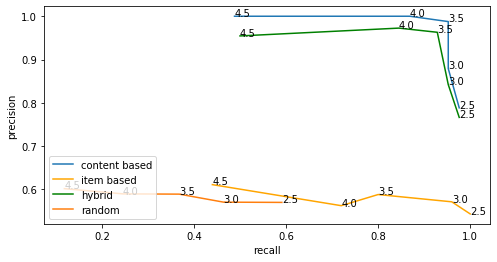

In [121]:
# create the precision-recall curve
threshold_recommended = [2.5, 3.0, 3.5, 4.0, 4.5]
threshold_used = 3.75

# content based filtering based on categories without 0
precisions_content_based = []
recalls_content_based = []
for number in threshold_recommended:
    recommended_items = recommended(predicted_ratings_CbF_V2, number)
    hidden_items = hidden(predicted_ratings_CbF_V2, number)
    used_items = used(predicted_ratings_CbF_V2, threshold_used)
    unused_items = unused(predicted_ratings_CbF_V2, threshold_used)
    # make the confusion matrix
    confusion_matrix_content_based = confusion(recommended_items, hidden_items, used_items, unused_items)
    # calculate precision and recall and add to list
    precision_content_based = precision(confusion_matrix_content_based)
    precisions_content_based.append(precision_content_based)
    recall_content_based = recall(confusion_matrix_content_based)
    recalls_content_based.append(recall_content_based)
# create the plot
precisions = precisions_content_based
recalls = recalls_content_based
plt.plot(recalls, precisions)
for r, p, t in zip(recalls, precisions, threshold_recommended):
    plt.text(r, p, t)
    
# item based filtering without 0
precisions_item_based = []
recalls_item_based = []
for number in threshold_recommended:
    recommended_items = recommended(df_predicted_cf_item_based_no_0, number)
    hidden_items = hidden(df_predicted_cf_item_based_no_0, number)
    used_items = used(df_predicted_cf_item_based_no_0, threshold_used)
    unused_items = unused(df_predicted_cf_item_based_no_0, threshold_used)
    # make the confusion matrix
    confusion_matrix_item_based = confusion(recommended_items, hidden_items, used_items, unused_items)
    # calculate precision and recall and add to list
    precision_item_based = precision(confusion_matrix_item_based)
    precisions_item_based.append(precision_item_based)
    recall_item_based = recall(confusion_matrix_item_based)
    recalls_item_based.append(recall_item_based)
# create the plot
precisions = precisions_item_based
recalls = recalls_item_based
plt.plot(recalls, precisions, color='orange')
for r, p, t in zip(recalls, precisions, threshold_recommended):
    plt.text(r, p, t)
    
# hybrid algorithm
precisions_hybrid = []
recalls_hybrid = []
for number in threshold_recommended:
    recommended_items = recommended(predicted_hybrid, number)
    hidden_items = hidden(predicted_hybrid, number)
    used_items = used(predicted_hybrid, threshold_used)
    unused_items = unused(predicted_hybrid, threshold_used)
    # make the confusion matrix
    confusion_matrix_hybrid = confusion(recommended_items, hidden_items, used_items, unused_items)
    # calculate precision and recall and add to list
    precision_hybrid = precision(confusion_matrix_hybrid)
    precisions_hybrid.append(precision_hybrid)
    recall_hybrid = recall(confusion_matrix_hybrid)
    recalls_hybrid.append(recall_hybrid)
# create the plot
precisions = precisions_hybrid
recalls = recalls_hybrid
plt.plot(recalls, precisions, color='green')
for r, p, t in zip(recalls, precisions, threshold_recommended):
    plt.text(r, p, t)

# random predictions
precisions_random = []
recalls_random = []
for number in threshold_recommended:
    recommended_items = recommended(predicted_random, number)
    hidden_items = hidden(predicted_random, number)
    used_items = used(predicted_random, threshold_used)
    unused_items = unused(predicted_random, threshold_used)
    # make the confusion matrix
    confusion_matrix_random = confusion(recommended_items, hidden_items, used_items, unused_items)
    # calculate precision and recall and add to list
    precision_random = precision(confusion_matrix_random)
    precisions_random.append(precision_random)
    recall_random = recall(confusion_matrix_random)
    recalls_random.append(recall_random)
# create the plot
precisions = precisions_random
recalls = recalls_random
plt.plot(recalls, precisions)
for r, p, t in zip(recalls, precisions, threshold_recommended):
    plt.text(r, p, t)

plt.rcParams["figure.figsize"] = [8,4]
plt.xlabel('recall') 
plt.ylabel('precision')
plt.legend(['content based', 'item based', 'hybrid', 'random'], loc = 'lower left')